In [1]:
from IPython import get_ipython

# Work file for plot

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
%qtconsole

Populating the interactive namespace from numpy and matplotlib


In [3]:
import arviz as az
import datetime
import matplotlib.dates as md
import os
import os.path
import pandas as pd
import pystan
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
sns.set_context('notebook')
sns.set_palette('colorblind')

In [4]:
loc_europe_EU = [
	'Austria', 
	'Belgium', 
	'Bulgaria', 
	'Croatia', 
	'Cyprus', 
	'Czech Republic', 
	'Denmark', 
	'Estonia', 
	'Finland', 
	'France', 
	'Germany', 
	'Greece', 
	'Hungary', 
	'Ireland', 
	'Italy', 
	'Latvia', 
	'Lithuania', 
	'Luxembourg', 
	'Malta', 
	'Netherlands', 
	'Poland', 
	'Portugal', 
	'Romania', 
	'Slovakia', 
	'Slovenia', 
	'Spain', 
	'Sweden']

loc_europe_others = [
	'Norway',
	'United Kingdom',
	'Switzerland']

loc_non_europe = [
	'United States',
	'Russia']

ACTIVE_COUNTRIES = list(set(loc_europe_EU + loc_europe_others + loc_non_europe))

In [5]:
def write_to_file(obj, name, ext):
    filename = 'data/' + name + '.' + ext
    try:
        obj.to_excel(filename)
    except:
        print("no folder, creating...")
        # import the os module
        import os

        # detect the current working directory
        path = os.getcwd()
        dirpath = path + "/data"
        print ("Path to created folder is %s" % dirpath)
        os.mkdir(dirpath)
        states.to_excel(filename)

 Download the dataset from Our World In Data (github rep)

In [6]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
states = pd.read_csv(url,
                     usecols=[1,2,3],
                     names=['state', 'date', 'positive'],
                     header=0,
                     parse_dates=['date']).sort_index()
states = states[states['state'].isin(ACTIVE_COUNTRIES)]

# write to file
write_to_file(states, 'stan_debug_pre', 'xlsx')

# fix cumulative negatives in cases
def adjust_negatives(states):

    p = states.shift(-1)
    states.loc[(states.state == p.state) & (states.positive > p.positive), 'positive'] = p.positive
    
    p = states.shift(-1)
    if (((states.state == p.state) & (states.positive > p.positive)).any()):
        states = adjust_negatives(states)
        return states
    else:
        return states

states = adjust_negatives(states)
states.positive = states.positive.apply(lambda x: int(x))

# write to file
write_to_file(states, 'stan_debug_post', 'xlsx')

states = states.set_index(['state', 'date'])
states = states.sort_index()





In [7]:
# customized layout

from datetime import datetime as dtime
from datetime import timedelta

date_now = dtime.now()
date_then = dtime.now() - timedelta(days=48)

rtlive = ["#5db044", "#da5d5d", "#95a5a6", "#e74c3c", "#34495e"]
sns.set_palette(rtlive)

In [8]:
def save_state_fits(fits, directory):
    try:
        os.makedirs(directory)
    except OSError:
        pass
    
    for k, f in fits.items():
        fname = os.path.join(directory, k + '.nc')
        fname_tmp = fname + '.temp'
        az.to_netcdf(f, fname_tmp)
        os.rename(fname_tmp, fname)
def load_state_fits(directory):
    fits = {}
    for f in glob.glob(os.path.join(directory, '*.nc')):
        k = os.path.splitext(os.path.split(f)[1])[0]
        fits[k] = az.from_netcdf(f)
    return fits

In [9]:
#save_state_fits(state_fits, 'state_fits_EUW')

 And make a plot that is similar to the one at http://rt.live

In [10]:
import glob
from collections import OrderedDict 

state_fits = load_state_fits('state_fits_EUW')
state_fits = OrderedDict(sorted(state_fits.items()))

In [11]:
# set customized palette
sns.set_palette(rtlive)

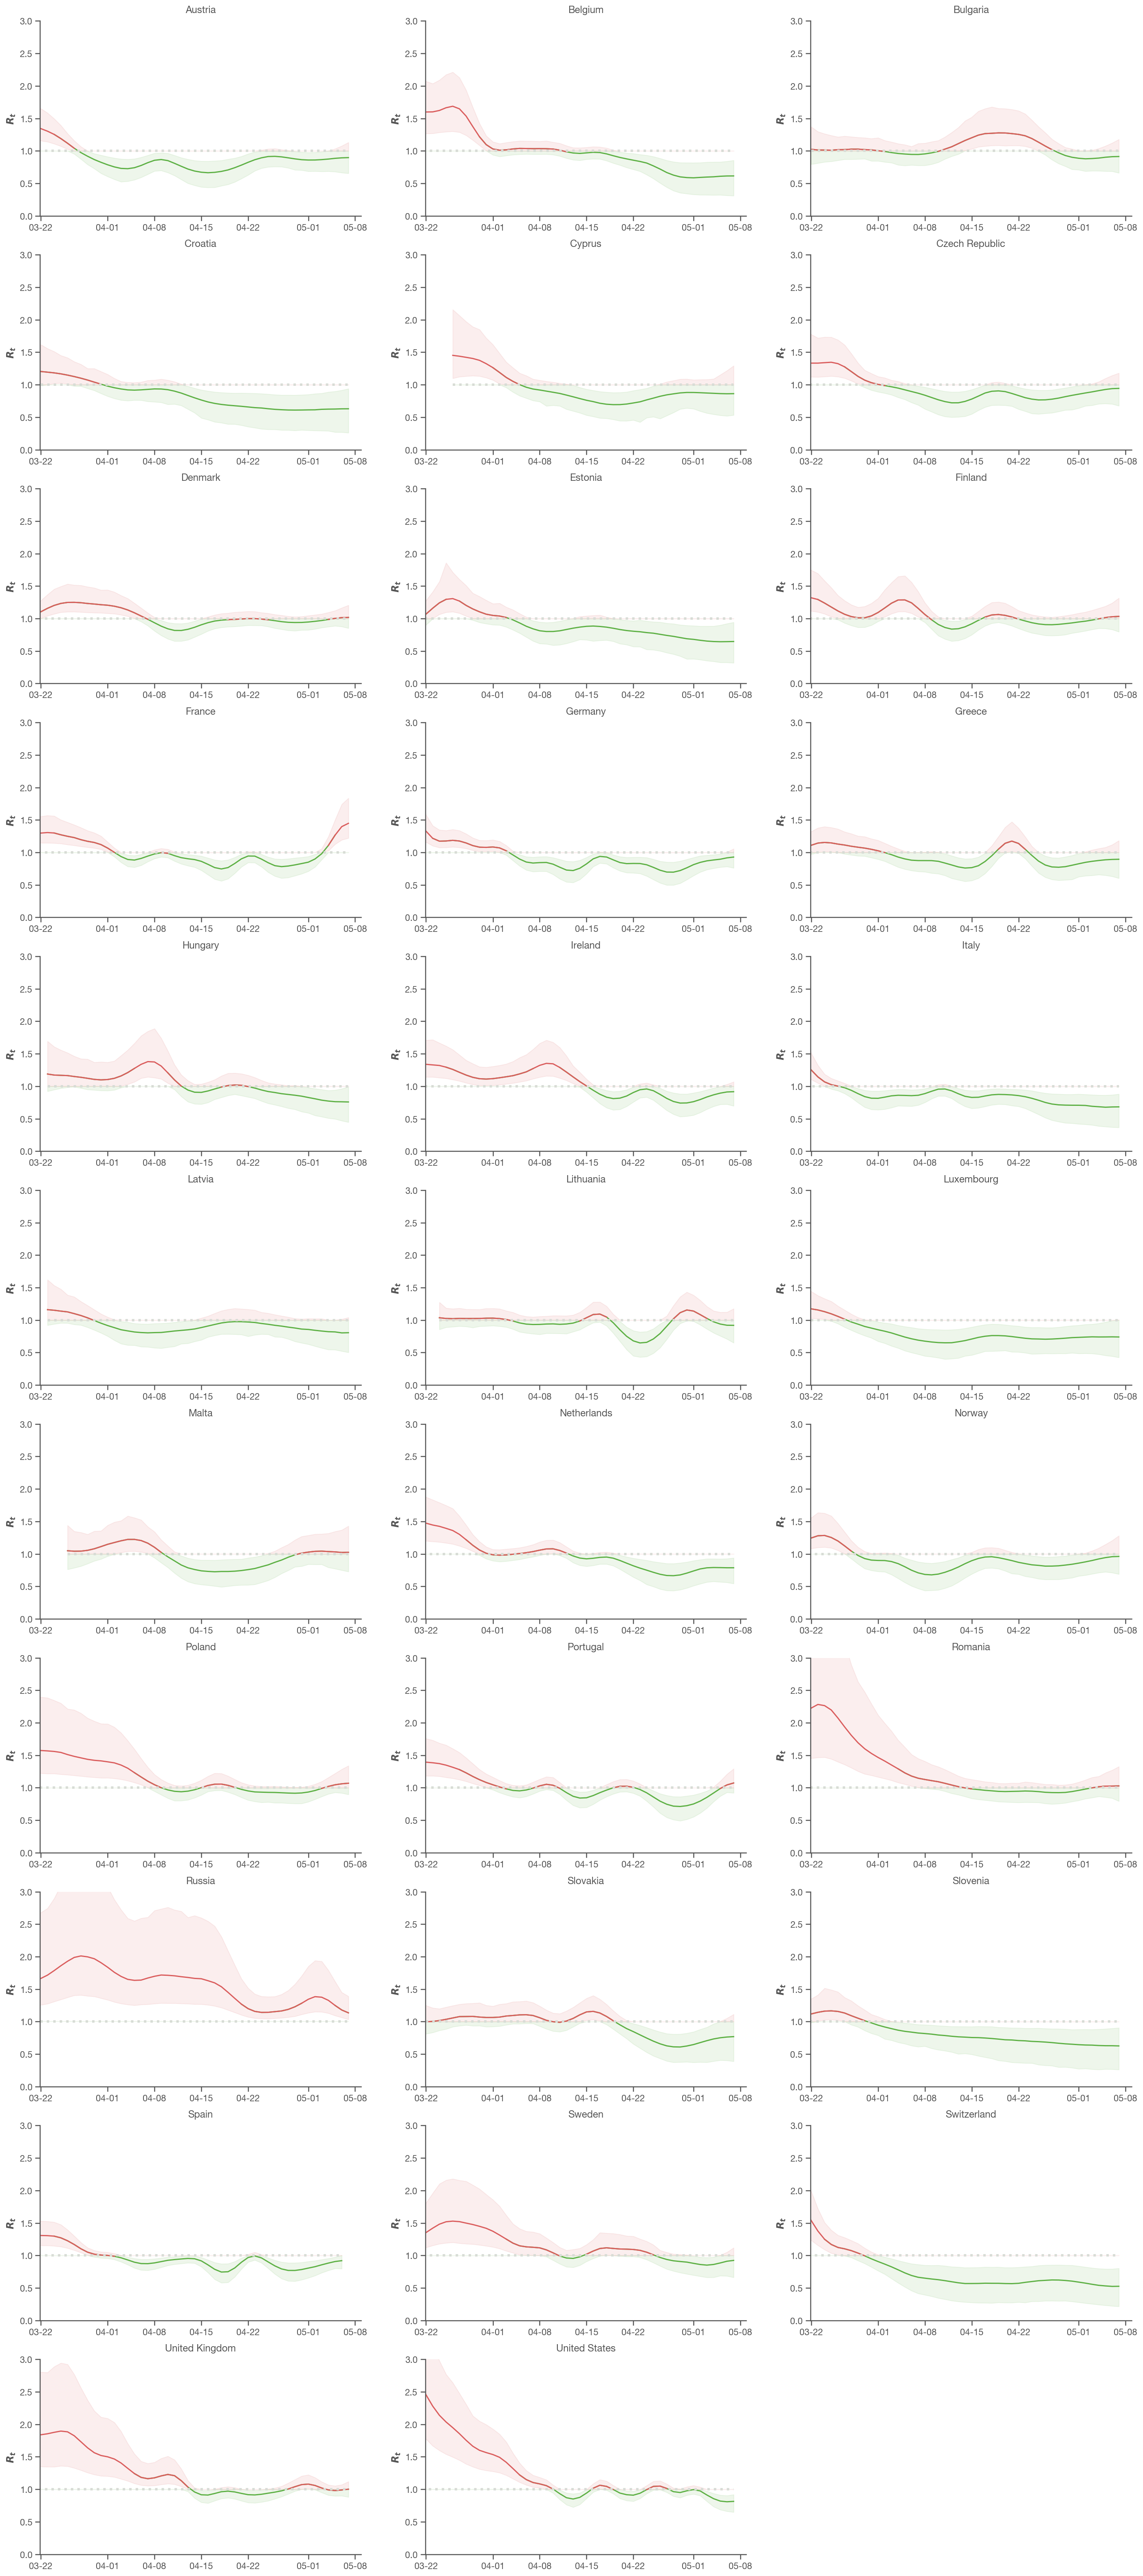

In [12]:
nc = 3
nr = 11
# temporarily limit states for plot testing
# state_count = 12

fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(24, 5*nr))

count = 0;
for idx, ((k,fit), ax) in enumerate(zip(state_fits.items(), axes.flatten())):
    
    #if count >= state_count:
    #    break
    
    m = np.median(fit.posterior.Rt, axis=(0,1))
    hh = np.percentile(fit.posterior.Rt, 97.5, axis=(0,1))
    h = np.percentile(fit.posterior.Rt, 84, axis=(0,1))
    l = np.percentile(fit.posterior.Rt, 16, axis=(0,1))
    ll = np.percentile(fit.posterior.Rt, 2.5, axis=(0,1))

    x = fit.posterior.Rt_dates.values
    line_1 = np.ones(len(x))

    # NOTE: try this approach instead (filling with NaN):
    m_good = m.copy()
    m_bad = m.copy()
    m_good[m_good > 1.30] = np.nan
    m_bad[m_bad <= 0.98] = np.nan
    
    ax.plot(x, m_good, ls='-', marker='', lw=1.5, color=sns.color_palette()[0])
    ax.plot(x, m_bad, ls='-', marker='', lw=1.5, color=sns.color_palette()[1])
    
    good_dates = m <= 1.0
    bad_dates = m > 1.0

    #ax.plot_date(x[good_dates], m[good_dates], ls='-', marker='', xdate=True, color=sns.color_palette()[0])
    #ax.fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.10, color=sns.color_palette()[0])
    
    ax.fill_between(x, np.where(hh<1, hh, 1) , np.where(ll<1, ll, 1), alpha=0.10, color=sns.color_palette()[0])
    
    #ax.plot_date(x[bad_dates], m[bad_dates], ls='-', marker='', xdate=True, color=sns.color_palette()[1])
    #ax.fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.10, color=sns.color_palette()[1])
    
    ax.fill_between(x, np.where(hh>1, hh, 1) , np.where(ll>1, ll, 1), alpha=0.10, color=sns.color_palette()[1])
    
    #ax.plot_date(x, m, ls='-', marker='', xdate=True, color=sns.color_palette()[0])
    ax.plot(x, line_1, ls='dotted', color = sns.xkcd_rgb["light grey"], lw=3)

    date_fmt = md.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(date_fmt)
    
    ax.set_title(k)
    ax.set_ylabel(r'$R_t$')

    ax.set_xlim([date_then, date_now])

    ax.set_ylim(bottom = 0,
                top = 3,
                auto = False)
    sns.despine()
    #y0, y1 = ax.get_ylim()
    #if y0 < 0:
    #    ax.set_ylim(0, y1)
    
    count +=1

else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

In [13]:
# reset to orig palette
sns.set_palette('colorblind')

Here is a nice plot that shows the distribution of $R_t$ at the latest day of sampling, ordered by its median value:

In [14]:
nc = 4
nd = 1000

d = {'state': [], 'Rt': []}
for k, f in state_fits.items():
    d = {'state': np.concatenate((d['state'], (k,)*(nc*nd))), 
         'Rt': np.concatenate((d['Rt'], f.posterior.Rt[:,:,-1].values.flatten()))}
df = pd.DataFrame(d)

sort_Rts = [np.median(fit.posterior.Rt[:,:,-1]) for fit in state_fits.values()]
state_order = np.array(list(state_fits.keys()))[np.argsort(sort_Rts)]

Compare to http://rt.live:

(-0.5, 31.5, 0, 2.5)

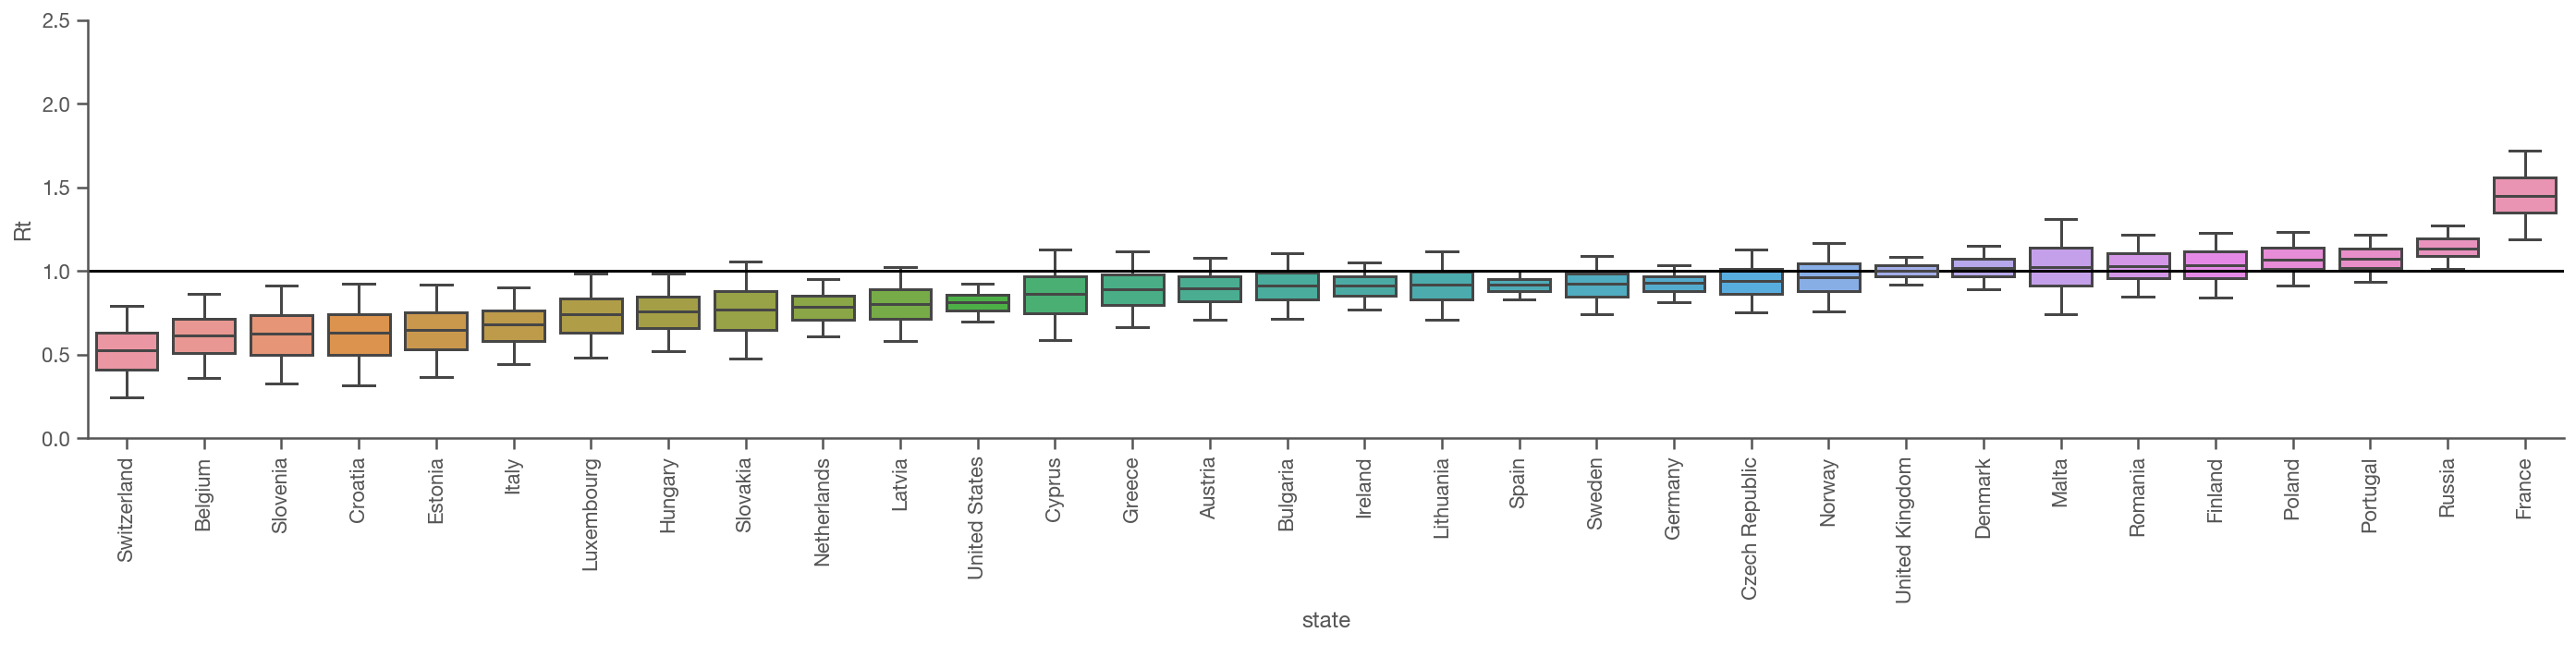

In [15]:
plt.figure(figsize=(24,4))
sns.boxplot(x='state', y='Rt', data=df, order=state_order, fliersize=0, whis=1.0/1.35, )
plt.axhline(1, color='k')
plt.xticks(rotation=90)
plt.axis(ymin=0, ymax=2.5)

Should check in on this model for $\tau$---in the states where it is well-measured, we favor a slightly smaller $\tau$ than the default prior.  Might be worth building a hierarchical model to re-infer $\tau$ from the national data....  Black line is the prior.

Text(0.5, 0, '$\\tau$ ($\\mathrm{d}$)')

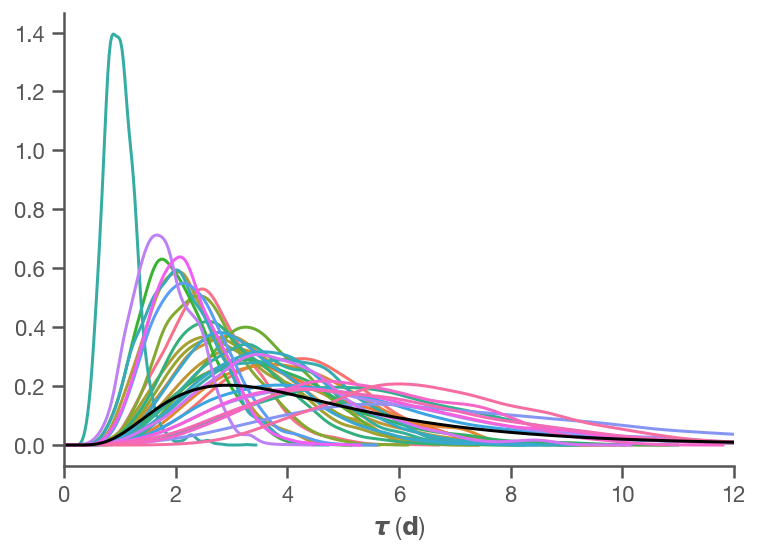

In [16]:
with sns.color_palette('husl', n_colors=len(state_fits)):
    for f in state_fits.values():
        sns.kdeplot(f.posterior.tau.values.flatten())
xs = np.linspace(0, 20, 1024)
plt.plot(xs, ss.lognorm(0.57, scale=np.exp(1.4)).pdf(xs), color='k')
plt.axis(xmin=0,xmax=12)

plt.xlabel(r'$\tau$ ($\mathrm{d}$)')

